In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [77]:
df = pd.read_csv("new_datasets/gramineas_2014_2025.csv")
df = df.set_index("fecha")
df.index = pd.to_datetime(df.index)

### Features

In [78]:
def create_features(df):
    df = df.copy()
    df['day'] = (df.index.month.astype(int)*12) + df.index.day.astype(int)
    df['month'] = df.index.month.astype(int)
    df['temperature_2m (°C)'] = df.get('temperature_2m (°C)')
    df['wind_speed_10m (km/h)'] = df.get('wind_speed_10m (km/h)')
    df['wind_gusts_10m (km/h)'] = df.get('wind_gusts_10m (km/h)')
    df['relative_humidity_2m (%)'] = df.get('relative_humidity_2m (%)')
    df['wind_direction_10m (°)'] = df.get('wind_direction_10m (°)')
    df['et0_fao_evapotranspiration (mm)'] = df.get('et0_fao_evapotranspiration (mm)')
    df['dew_point_2m (°C)'] = df.get('dew_point_2m (°C)')
    df['rain (mm)'] = df.get('rain (mm)')
    df['vapour_pressure_deficit (kPa)'] = df.get('vapour_pressure_deficit (kPa)')
    df['soil_moisture_0_to_7cm (m³/m³)'] = df.get('soil_moisture_0_to_7cm (m³/m³)')
    df['soil_temperature_0_to_7cm (°C)'] = df.get('soil_temperature_0_to_7cm (°C)')
    df['cloud_cover (%)'] = df.get('cloud_cover (%)')
    df['shortwave_radiation (W/m²)'] = df.get('shortwave_radiation (W/m²)')

    df['Benceno (ug/m3)'] = df.get('Benceno (ug/m3)')
    df['CO (mg/m3)'] = df.get('CO (mg/m3)')
    df['NO (ug/m3)'] = df.get('NO (ug/m3)')
    df['NO2 (ug/m3)'] = df.get('NO2 (ug/m3)')
    df['NOx (ug/m3)'] = df.get('NOx (ug/m3)')
    df['O3 (ug/m3)'] = df.get('O3 (ug/m3)')
    df['PM10 (ug/m3)'] = df.get('PM10 (ug/m3)')
    df['PM2.5 (ug/m3)'] = df.get('PM2.5 (ug/m3)')
    df['Tolueno (ug/m3)'] = df.get('Tolueno (ug/m3)')

    df['precip_autumn_last_year'] = df.get('precip_autumn_last_year')
    df['precip_winter_last_year'] = df.get('precip_winter_last_year')
    df['temp_mean_spring_summer_last'] = df.get('temp_mean_spring_summer_last')
    df['humidity_sum_spring_summer_last'] = df.get('humidity_sum_spring_summer_last')
    df['co2_mean_april_may_last'] = df.get('co2_mean_april_may_last')
    df['o3_mean_april_may_last'] = df.get('o3_mean_april_may_last')
    df['no2_mean_april_may_last'] = df.get('no2_mean_april_may_last')
    df['drought_days_summer_last'] = df.get('drought_days_summer_last')
    df['growing_degree_days_last'] = df.get('growing_degree_days_last')

    return df

df = create_features(df)

### Lag Features

In [79]:
def add_lags(df):
    target_map = df['granos_de_polen_x_metro_cubico'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['lag7'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag28'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag364'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    return df

### Train

In [80]:
tss = TimeSeriesSplit(n_splits=5, test_size=7, gap=1)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    train = add_lags(train)
    test = create_features(test)
    test = add_lags(test)

    FEATURES = ['day',
            'month',
            'temperature_2m (°C)',
            'wind_speed_10m (km/h)',
            'wind_gusts_10m (km/h)',
            'relative_humidity_2m (%)',
            'wind_direction_10m (°)',
            'et0_fao_evapotranspiration (mm)',
            'dew_point_2m (°C)',
            'rain (mm)',
            'vapour_pressure_deficit (kPa)',
            'soil_moisture_0_to_7cm (m³/m³)',
            'soil_temperature_0_to_7cm (°C)',
            'cloud_cover (%)',
            'shortwave_radiation (W/m²)',
            'Benceno (ug/m3)',
            'CO (mg/m3)', 
            'NO (ug/m3)', 
            'NO2 (ug/m3)', 
            'NOx (ug/m3)', 
            'O3 (ug/m3)', 
            'PM10 (ug/m3)', 
            'PM2.5 (ug/m3)',
            'Tolueno (ug/m3)',
            'precip_autumn_last_year',
            'precip_winter_last_year',
            'temp_mean_spring_summer_last',
            'humidity_sum_spring_summer_last',
            'co2_mean_april_may_last',
            'o3_mean_april_may_last',
            'no2_mean_april_may_last',
            'drought_days_summer_last',
            'growing_degree_days_last',
            'lag1',
            'lag2',
            'lag7',
            'lag28',
            'lag364'
        ]
    TARGET = 'granos_de_polen_x_metro_cubico'

    # Eliminar filas nulas
    train = train.dropna(subset=[TARGET])

    X_train = train[FEATURES]
    y_train = train[TARGET]

    # Eliminar filas nulas
    test = test.dropna(subset=[TARGET])

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

[0]	validation_0-rmse:33.78072	validation_1-rmse:1.15875
[73]	validation_0-rmse:22.53354	validation_1-rmse:1.24238


c:\Users\sergi\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [13:55:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:33.75033	validation_1-rmse:0.51979
[50]	validation_0-rmse:25.05695	validation_1-rmse:1.37312


c:\Users\sergi\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [13:55:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:33.71999	validation_1-rmse:0.52332
[50]	validation_0-rmse:25.03447	validation_1-rmse:1.42942


c:\Users\sergi\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [13:55:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:33.68973	validation_1-rmse:0.52330
[50]	validation_0-rmse:25.01217	validation_1-rmse:1.42840


c:\Users\sergi\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [13:55:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:33.65955	validation_1-rmse:0.51976
[50]	validation_0-rmse:24.99156	validation_1-rmse:1.38961
Score across folds 0.6150
Fold scores:[0.9886996040177195, 0.5197945394132438, 0.5233229050999981, 0.5233010014100355, 0.5197612343019433]


c:\Users\sergi\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [13:55:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


### Predict the future

In [81]:
future = pd.date_range('2025-08-03','2025-08-10')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()


In [82]:
# Añadir predicciones a future_w_features
for col in FEATURES:
    if col not in ['day', 'month'] and 'lag' not in col and col in future_w_features.columns:
        future_w_features[col] = future_w_features[col].fillna(df[col].mean())
future_w_features

,Unnamed: 0.1,Unnamed: 0,tipo_polinico,granos_de_polen_x_metro_cubico,año,temperature_2m (°C),wind_speed_10m (km/h),wind_gusts_10m (km/h),relative_humidity_2m (%),wind_direction_10m (°),...,growing_degree_days_last,polen_last_year,day,month,isFuture,lag1,lag2,lag7,lag28,lag364
2025-08-03,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,2478.634327,NaN,99,8,True,1.0,1.0,2.0,6.0,1.0
2025-08-04,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,2478.634327,NaN,100,8,True,NaN,1.0,2.0,10.0,1.0
2025-08-05,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,2478.634327,NaN,101,8,True,NaN,NaN,1.0,7.0,4.0
2025-08-06,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,2478.634327,NaN,102,8,True,NaN,NaN,0.0,6.0,2.0
2025-08-07,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,2478.634327,NaN,103,8,True,NaN,NaN,1.0,10.0,1.0
2025-08-08,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,2478.634327,NaN,104,8,True,NaN,NaN,1.0,11.0,1.0
2025-08-09,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,2478.634327,NaN,105,8,True,NaN,NaN,1.0,3.0,1.0
2025-08-10,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,2478.634327,NaN,106,8,True,NaN,NaN,NaN,6.0,2.0


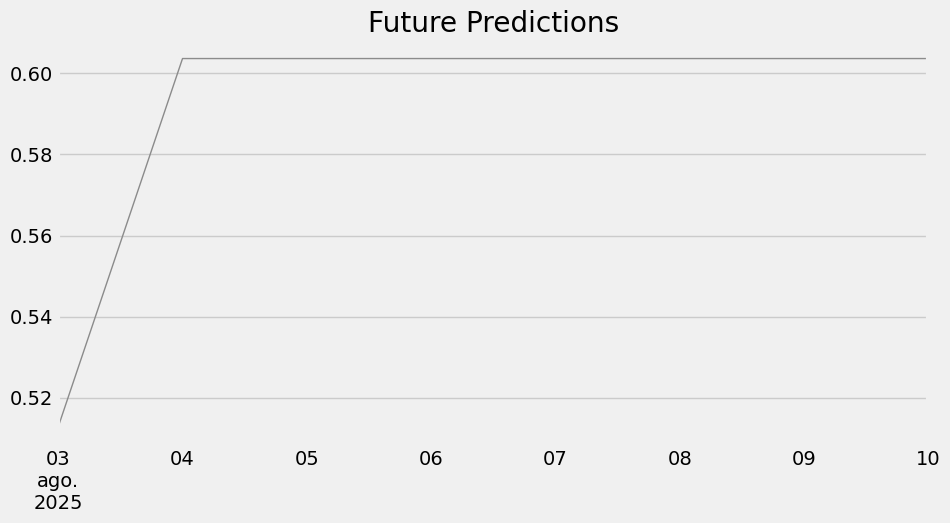

,Unnamed: 0.1,Unnamed: 0,tipo_polinico,granos_de_polen_x_metro_cubico,año,temperature_2m (°C),wind_speed_10m (km/h),wind_gusts_10m (km/h),relative_humidity_2m (%),wind_direction_10m (°),...,polen_last_year,day,month,isFuture,lag1,lag2,lag7,lag28,lag364,pred
2025-08-03,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,NaN,99,8,True,1.0,1.0,2.0,6.0,1.0,0.512843
2025-08-04,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,NaN,100,8,True,NaN,1.0,2.0,10.0,1.0,0.603645
2025-08-05,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,NaN,101,8,True,NaN,NaN,1.0,7.0,4.0,0.603645
2025-08-06,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,NaN,102,8,True,NaN,NaN,0.0,6.0,2.0,0.603645
2025-08-07,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,NaN,103,8,True,NaN,NaN,1.0,10.0,1.0,0.603645
2025-08-08,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,NaN,104,8,True,NaN,NaN,1.0,11.0,1.0,0.603645
2025-08-09,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,NaN,105,8,True,NaN,NaN,1.0,3.0,1.0,0.603645
2025-08-10,NaN,NaN,NaN,NaN,NaN,10.945119,13.126879,25.627461,74.679833,197.547948,...,NaN,106,8,True,NaN,NaN,NaN,6.0,2.0,0.603645


In [83]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()
future_w_features